In [279]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [280]:
datos = loadmat('pruebaVictor.mat')

In [281]:
datos['Fv']

array([[250.  ],
       [250.01],
       [250.02],
       ...,
       [329.98],
       [329.99],
       [330.  ]], shape=(8001, 1))

In [282]:
signal = datos['H']

In [283]:
#phi = np.load('basis_functions_complete_space.npz')['x']

In [284]:
phi = np.load('H_distance_8001_f0=50.0_BW=40.0.npz')['x']

In [285]:
def scalar_product(h1, h2):

    return np.sum(np.conj(h1)*(h2))

def module(h):

    return np.sqrt(scalar_product(h, h))

In [286]:
freqs_ghz = datos['Fv']

In [287]:
Xf = signal

In [288]:
freqs_ghz = freqs_ghz.ravel()      # --> (8001,)
Xf = Xf.ravel() 
# Pasamos a Hz
freqs_hz = freqs_ghz * 1e9

N = len(freqs_hz)

# Resolución en frecuencia
df = freqs_hz[1] - freqs_hz[0]    # ~ 10e6 Hz

# Ventana temporal equivalente (aprox): T = 1/df
T = 1.0 / df
dt = T / N
t = np.arange(N) * dt             # eje temporal (s)

# 1) Señal en *banda base* (envolvente compleja) vía IFFT
# Escalado sencillo: la IFFT asume sum_k X[k] e^{j2π kn/N} / N
# Nosotros queremos algo proporcional a sum_k Xf[k] e^{j2π f_k t_n} df
# Para muchos usos prácticos, basta:
x_bb = np.fft.ifft(Xf)           # envolvente compleja (banda base)

# 2) Si quieres la señal *banda pasante* centrada en 250 GHz:
f0 = freqs_hz[0]                 # 250 GHz en Hz
x_bp = x_bb * np.exp(1j * 2 * np.pi * f0 * t)

In [289]:
Q_bb_alt = []
for phi_ in phi:
    Q_bb_alt.append(scalar_product(phi_, x_bb))

In [290]:
Q_bb_alt_filt = keep_n_largest_components(Q_bb_alt, 10)

In [291]:
recovered_bb_alt = np.array(Q_bb_alt)@phi

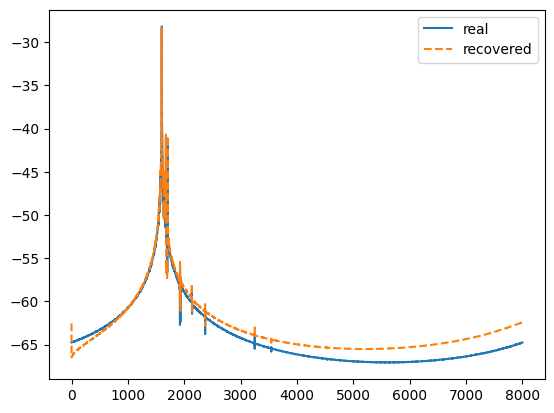

In [292]:
plt.plot(10*np.log10(np.abs(x_bb)), label='real')
plt.plot(10*np.log10(np.abs(recovered_bb_alt)), label='recovered', linestyle='--')

plt.legend()

In [293]:
Phi = np.column_stack(phi)          # (8001, 8001) si tienes 8001 vectores
c = np.linalg.solve(Phi.conj().T @ Phi, Phi.conj().T @ x_bb)
x_hat = Phi @ c


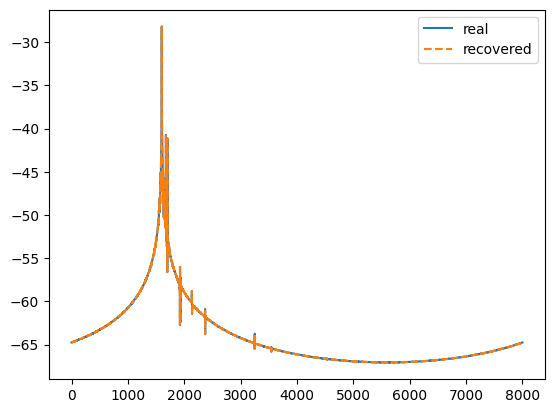

In [294]:
plt.plot(10*np.log10(np.abs(x_bb)), label='real')
plt.plot(10*np.log10(np.abs(x_hat)), label='recovered', linestyle='--')

plt.legend()

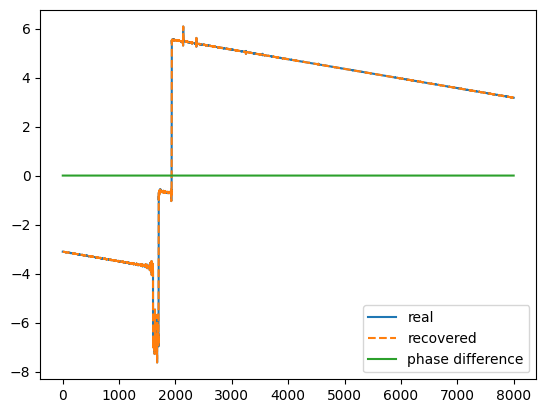

In [295]:
plt.plot((np.unwrap(np.angle(x_bb))), label='real')
plt.plot(np.unwrap(np.angle(x_hat)), label='recovered', linestyle='--')
plt.plot(np.unwrap(np.angle(x_hat)) - (np.unwrap(np.angle(x_bb))), label='phase difference')
plt.legend()

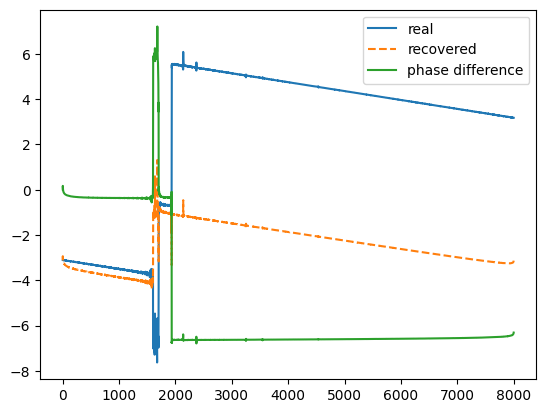

In [296]:
plt.plot((np.unwrap(np.angle(x_bb))), label='real')
plt.plot(np.unwrap(np.angle(recovered_bb_alt)), label='recovered', linestyle='--')
plt.plot(np.unwrap(np.angle(recovered_bb_alt)) - (np.unwrap(np.angle(x_bb))), label='phase difference')
plt.legend()

### Actual measurements

In [297]:
measurements = loadmat('pruebaVictor-1.mat')

In [298]:
def normalize_vectors(X):
    """
    X: matriz 2D (num_vectors, vector_length)
       con componentes complejas.
    
    Devuelve una matriz del mismo tamaño con cada vector normalizado
    a norma 1: x / ||x||.
    """
    X = np.asarray(X, dtype=np.complex128)

    # norma de cada vector (fila)
    norms = np.linalg.norm(X, axis=1, keepdims=True)

    # evitar división por cero
    norms[norms == 0] = 1.0

    # normalizar
    return X / norms

In [299]:
meas = measurements['h'].reshape(-1)

In [300]:
Q_meas = []
for phi_ in phi:
    Q_meas.append(scalar_product(phi_, meas))

In [301]:
recovered_meas = np.array(Q_meas)@phi

In [302]:
import numpy as np

def keep_n_largest_components(x, n):
    """
    x: vector 1D
    n: número de componentes a conservar (por valor absoluto)
    """
    x = np.asarray(x)
    y = np.zeros_like(x)

    # índices de los n mayores valores absolutos
    idx = np.argpartition(np.abs(x), -n)[-n:]

    # copiar solo esos valores
    y[idx] = x[idx]
    return y


In [303]:
Q_meas_filtered = keep_n_largest_components(Q_meas, 800)

In [304]:
recovered_meas_filt = np.array(Q_meas)@phi

C:\Users\LabCETIC\AppData\Local\Temp\ipykernel_14840\491798111.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(np.abs(meas)), label='real')


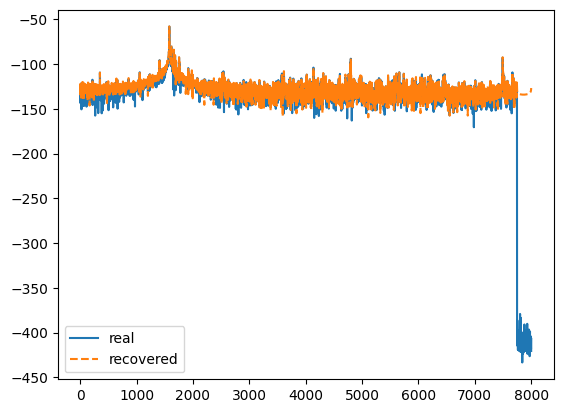

In [305]:
plt.plot(20*np.log10(np.abs(meas)), label='real')
plt.plot(20*np.log10(np.abs(recovered_meas_filt)), label='recovered', linestyle='--')

plt.legend()

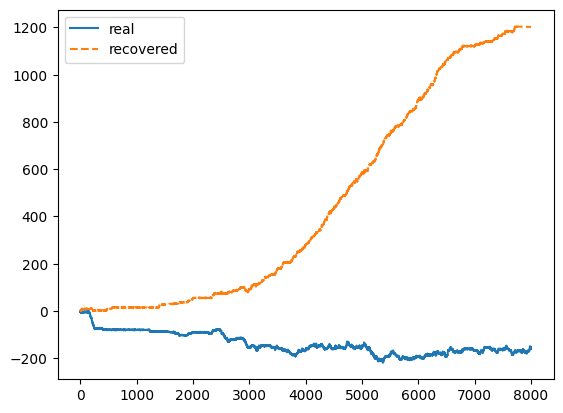

In [306]:
plt.plot((np.unwrap(np.angle(meas))), label='real')
plt.plot((np.unwrap(np.angle(recovered_meas_filt))), label='recovered', linestyle='--')

plt.legend()

## Resolviendo la expansión por mínimos cuadrados

In [307]:
c_meas = np.linalg.solve(Phi.conj().T @ Phi, Phi.conj().T @ meas)
x_hat_meas = Phi @ c_meas

In [334]:
c_meas_filtered = keep_n_largest_components(c_meas, 100)

In [335]:
x_hat_meas_filt = Phi @ c_meas_filtered

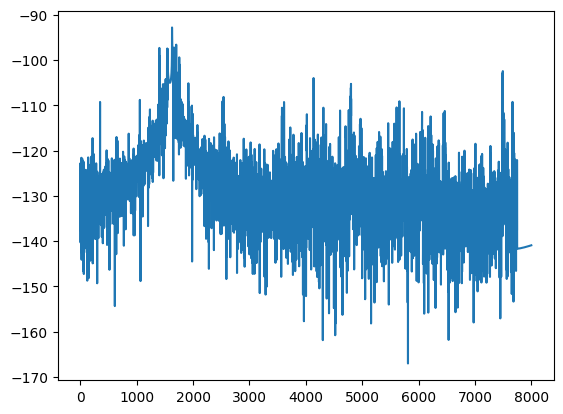

In [336]:
plt.plot(20*np.log10(np.abs(meas-x_hat_meas_filt)))

In [337]:
from scipy.stats import gaussian_kde
import numpy as np

re = np.real(meas-x_hat_meas_filt)   # tus muestras
im = np.imag(meas-x_hat_meas_filt)

data = re 

kde_r = gaussian_kde(data)     # por defecto kernel gaussiano
x_r = np.linspace(data.min(), data.max(), 1000)
pdf_r = kde_r(x_r)


In [338]:
data = im
kde_i = gaussian_kde(data)     # por defecto kernel gaussiano
x_i = np.linspace(data.min(), data.max(), 1000)
pdf_i = kde_i(x_i)

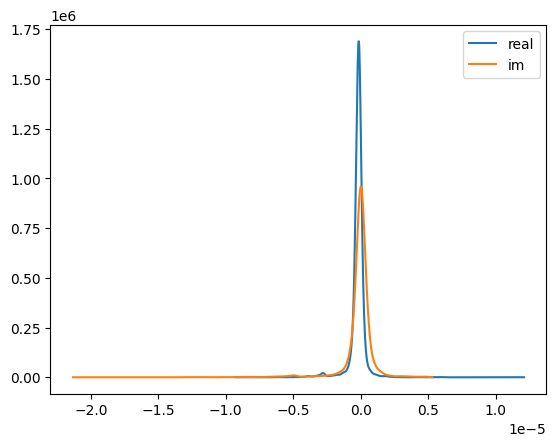

In [339]:
plt.plot(x_r, pdf_r, label='real')
plt.plot(x_i, pdf_i, label='im')
plt.legend()


C:\Users\LabCETIC\AppData\Local\Temp\ipykernel_14840\3156066517.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(np.abs(meas)), label='real')


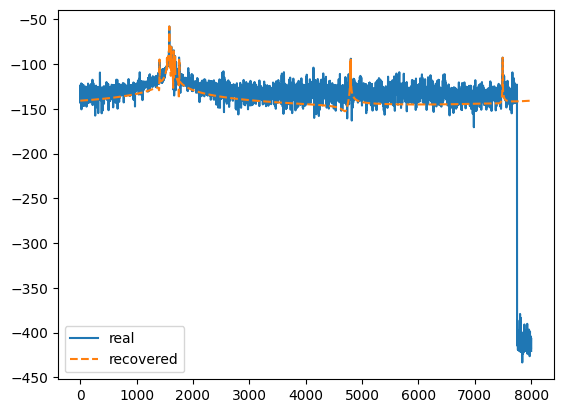

In [340]:
plt.plot(20*np.log10(np.abs(meas)), label='real')
plt.plot(20*np.log10(np.abs(x_hat_meas_filt)), label='recovered', linestyle='--')
#plt.xlim(900, 2000)
plt.legend()

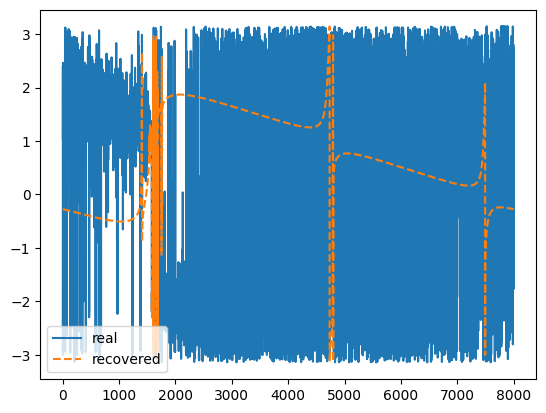

In [341]:
plt.plot(((np.angle(meas))), label='real')
plt.plot(((np.angle(x_hat_meas_filt))), label='recovered', linestyle='--')

plt.legend()

In [342]:
Xf = np.fft.fft(x_hat_meas_filt)
Xbb = np.fft.fft(meas)

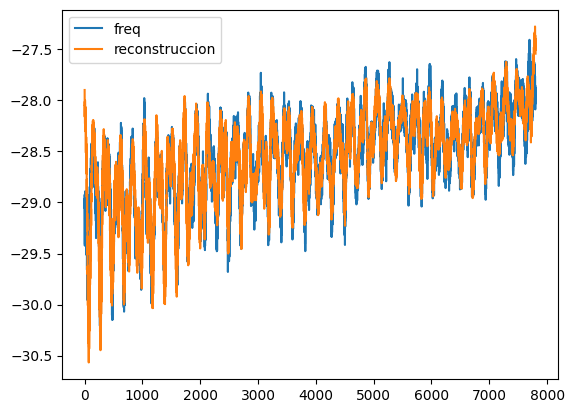

In [347]:
plt.plot(10*np.log10(np.abs(Xbb))[100:-100], label='freq')
plt.plot(10*np.log10(np.abs(Xf))[100:-100], label='reconstruccion')
plt.legend()

In [344]:
err_rel_freq = np.abs((10*np.log10(np.abs(Xbb)) - 10*np.log10(np.abs(Xf)))/(10*np.log10(np.abs(Xbb))))

In [345]:
np.sum(err_rel_freq)

np.float64(45.227378491827324)

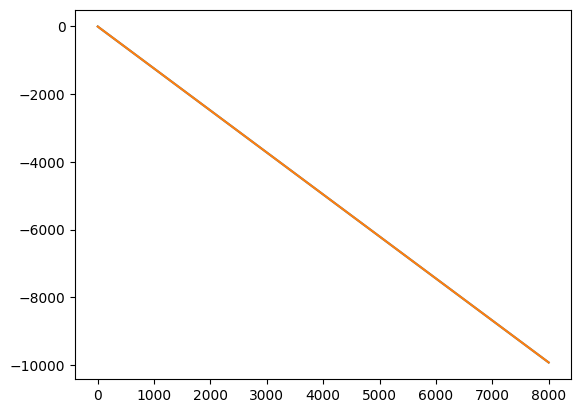

In [346]:
plt.plot(np.unwrap(np.angle(Xf)), label='freq')
plt.plot(np.unwrap(np.angle(Xbb)), label='freq')